# Set up

In [1]:
! pip install -q datasets
! pip install -q transformers -U
! pip install -q transformers[torch] -U
! pip install -q sentencepiece
! pip install -q evaluate
! pip install -q bert_score
! pip install -q -U accelerate
! pip install -q peft
! pip install -q huggingface-hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# CpgQA

In [ ]:
from datasets import load_dataset

dataset = load_dataset("legacy107/bioasq10b-factoid")

# Model

In [2]:
model_nm = "google/flan-t5-large"
max_length = 512
max_target_length = 200
checkpoint = "flan-t5-large-ia3-bioasq-paraphrase"
username = "legacy107"

In [5]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
import evaluate


def evaluate_qa(predicted_result):

    squad_metric = evaluate.load("squad")
    predictions = [
        {"prediction_text": answer, "id": str(id)}
        for id, answer in enumerate(predicted_result["output"])
    ]
    references = [
        {
            "answers": {"answer_start": [-1], "text": [ds["long_answer"]]},
            "id": str(id),
        }
        for id, ds in enumerate(predicted_result)
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=predictions, references=references
    )

    return results

# Evaluate prompting

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_nm, device_map="auto")
model = AutoModelForSeq2SeqLM.from_pretrained(model_nm, device_map="auto")

In [ ]:
import torch


def interfere_prompt(ds):
    qa_input = (
        f"question: {ds['question']}. Paraphrase the answer to make it more natural "
        f"answer: {ds['answer']}"
    )
    input_ids = tokenizer(
        qa_input,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length,
    ).to(torch.device("cuda"))
    outputs = model.generate(**input_ids, max_new_tokens=max_target_length)
    ds["output"] = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return ds


model.eval()
with torch.no_grad():
    predicted_result = dataset["test"].map(interfere_prompt, batched=False)

In [ ]:
evaluate_qa(predicted_result)

pretrained: 'exact_match': 0.6024096385542169, 'f1': 31.083989731652704

In [ ]:
import pandas as pd

results = []
for idx in range(len(predicted_result)):
    result = evaluate_qa(predicted_result.select([idx]))["squad"]
    results.append([result["exact_match"], result["f1"]])

df = pd.DataFrame(results, columns=["em", "f1"])

<Axes: >

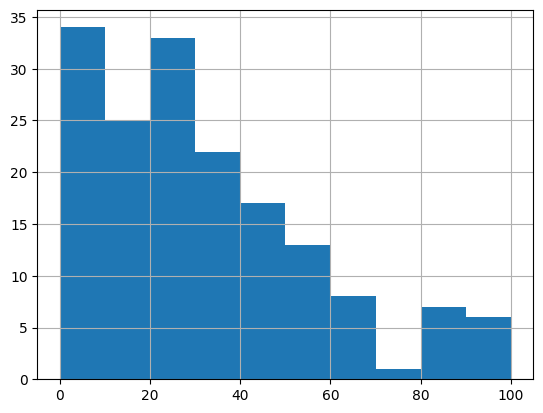

In [14]:
df["f1"].hist()

# IA3

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModelForSeq2SeqLM, get_peft_config

config = {
    "peft_type": "IA3",
    "task_type": "SEQ_2_SEQ_LM",
    "inference_mode": False,
    "target_modules": ["q", "v"],
}

peft_config = get_peft_config(config)
tokenizer = AutoTokenizer.from_pretrained(model_nm)
model = AutoModelForSeq2SeqLM.from_pretrained(model_nm)
peft_model = PeftModelForSeq2SeqLM(model, peft_config)
peft_model.print_trainable_parameters()

In [ ]:
def qa_prompt_preprocess(ds):
    input = (
        f"question: {ds['question']}. Paraphrase the answer to make it more natural "
        f"answer: {ds['answer']}"
    )
    model_inputs = tokenizer(input, max_length=max_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(
        text_target=ds["long_answer"], max_length=max_target_length, truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


seq2seq_dataset = {
    "train": dataset["train"].map(qa_prompt_preprocess, batched=False),
    "test": dataset["test"].map(qa_prompt_preprocess, batched=False),
}

In [9]:
seq2seq_dataset["train"] = seq2seq_dataset["train"].remove_columns(
    ["id", "question", "long_answer", "answer", "context"]
)
seq2seq_dataset["test"] = seq2seq_dataset["test"].remove_columns(
    ["id", "question", "long_answer", "answer", "context"]
)

In [ ]:
squad_metric = evaluate.load("squad")
bleu_metrics = evaluate.load("bleu")


def compute_metrics(pred):
    labels_ids, pred_ids = pred

    pred_ids[pred_ids == -100] = tokenizer.pad_token_id
    predictions = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    references = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    squad_predictions = [
        {"prediction_text": answer, "id": str(id)}
        for id, answer in enumerate(predictions)
    ]
    squad_references = [
        {
            "answers": {"answer_start": [-1], "text": [answer]},
            "id": str(id),
        }
        for id, answer in enumerate(references)
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=squad_predictions, references=squad_references
    )

    results["bleu"] = bleu_metrics.compute(
        predictions=predictions, references=references
    )

    return results

In [11]:
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from transformers.trainer_callback import TrainerCallback
import os


class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args,
        state,
        control,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(
            args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}"
        )

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control

In [13]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

bs = 2
eval_bs = 1
epochs = 16
lr = 3e-3
steps = 200
max_steps = 10000
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./{checkpoint}",
    learning_rate=lr,
    # per_device_train_batch_size=bs,
    # per_device_eval_batch_size=eval_bs,
    auto_find_batch_size=True,
    # num_train_epochs=epochs,
    max_steps=max_steps,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=steps,
    logging_steps=steps,
    evaluation_strategy="steps",
    eval_steps=steps,
    predict_with_generate=True,
    generation_max_length=max_target_length,
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=peft_model,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt",
)

trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=seq2seq_dataset["train"].with_format("torch"),
    eval_dataset=seq2seq_dataset["test"].with_format("torch"),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[SavePeftModelCallback],
)

In [ ]:
trainer.train()

In [ ]:
trainer.model.save_pretrained(checkpoint)
tokenizer.save_pretrained(checkpoint)

trainer.model.push_to_hub(checkpoint)
tokenizer.push_to_hub(checkpoint)

# Evaluate from checkpoint

In [ ]:
from transformers import AutoTokenizer
from peft import AutoPeftModelForSeq2SeqLM

model_checkpoint = f"{username}/{checkpoint}"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, device_map="auto")
checkpoint_model = AutoPeftModelForSeq2SeqLM.from_pretrained(
    model_checkpoint, device_map="auto"
)

In [ ]:
import torch


def interfere_prompt(ds):
    qa_input = (
        f"question: {ds['question']}. Paraphrase the answer to make it more natural "
        f"answer: {ds['answer']}"
    )
    input_ids = tokenizer(
        qa_input,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length,
    ).to(torch.device("cuda"))
    outputs = checkpoint_model.generate(**input_ids, max_new_tokens=max_target_length)
    ds["output"] = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return ds


checkpoint_model.eval()
with torch.no_grad():
    predicted_result = dataset["test"].map(interfere_prompt, batched=False)

In [18]:
evaluate_qa(predicted_result)

{'squad': {'exact_match': 7.831325301204819, 'f1': 50.17888393034603}}

finetuned: 'exact_match': 7.831325301204819, 'f1': 50.17888393034603

In [12]:
import pandas as pd

results = []
for idx in range(len(predicted_result)):
    result = evaluate_qa(predicted_result.select([idx]))["squad"]
    results.append([result["exact_match"], result["f1"]])

df = pd.DataFrame(results, columns=["em", "f1"])

<Axes: >

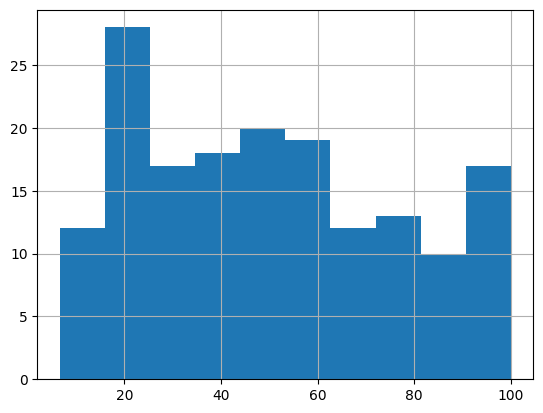

In [21]:
df["f1"].hist()

# Try inference on CpgQA

In [ ]:
from datasets import load_dataset

cpgqa_dataset_name = (
    "minh21/cpgQA-v1.0-unique-context-test-10-percent-validation-10-percent"
)
cpgqa_dataset = load_dataset(cpgqa_dataset_name, use_auth_token=True)
cpgqa_dataset = cpgqa_dataset.remove_columns(["title", "id"])
cpgqa_dataset = cpgqa_dataset.rename_column("answer_text", "answer")

In [ ]:
checkpoint_model.eval()
with torch.no_grad():
    predicted_result = cpgqa_dataset["test"].map(interfere_prompt, batched=False)

In [ ]:
predicted_result[70]